In [17]:
%pip install tensorflow keras opencv-python matplotlib numpy
%pip install split-folders
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ------------------------- -------------- 7.1/11.1 MB 39.6 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 36.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
import shutil
import random

# Sökvägen till ditt dataset
INPUT_FOLDER = "cnn_data/"
OUTPUT_FOLDER = "cnn_data_split/"
SPLIT_RATIOS = (0.7, 0.2, 0.1)  # Train: 70%, Val: 20%, Test: 10%

# Skapa mapparna för split
for split in ["train", "val", "test"]:
    for category in ["snowboarder", "skier"]:
        os.makedirs(os.path.join(OUTPUT_FOLDER, split, category), exist_ok=True)

# Funktion för att splitta datasetet
def split_data(category):
    img_dir = os.path.join(INPUT_FOLDER, category, "images")
    label_dir = os.path.join(INPUT_FOLDER, category, "labels")

    # Hämta alla bildfiler
    img_files = sorted(os.listdir(img_dir))  # Sortera för säkerhets skull
    random.shuffle(img_files)  # Blanda datan

    # Beräkna antal filer per split
    total_files = len(img_files)
    train_idx = int(SPLIT_RATIOS[0] * total_files)
    val_idx = train_idx + int(SPLIT_RATIOS[1] * total_files)

    # Dela upp filerna
    splits = {
        "train": img_files[:train_idx],
        "val": img_files[train_idx:val_idx],
        "test": img_files[val_idx:]
    }

    # Kopiera filer till respektive mapp
    for split, files in splits.items():
        for file in files:
            img_path = os.path.join(img_dir, file)
            label_path = os.path.join(label_dir, file.replace(".jpg", ".txt"))

            # Kopiera bild
            shutil.copy(img_path, os.path.join(OUTPUT_FOLDER, split, category, file))

            # Kopiera label om den finns
            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(OUTPUT_FOLDER, split, category, file.replace(".jpg", ".txt")))

# Splitta både snowboarders och skiers
split_data("snowboarder")
split_data("skier")

print("✅ Datasetet har delats upp i train, val och test!")



✅ Datasetet har delats upp i train, val och test!


In [8]:
import os

print("Train - snowboarder:", len(os.listdir("cnn_data_split/train/snowboarder")))
print("Train - skier:", len(os.listdir("cnn_data_split/train/skier")))
print("Val - snowboarder:", len(os.listdir("cnn_data_split/val/snowboarder")))
print("Val - skier:", len(os.listdir("cnn_data_split/val/skier")))
print("Test - snowboarder:", len(os.listdir("cnn_data_split/test/snowboarder")))
print("Test - skier:", len(os.listdir("cnn_data_split/test/skier")))


Train - snowboarder: 1336
Train - skier: 2338
Val - snowboarder: 382
Val - skier: 668
Test - snowboarder: 192
Test - skier: 336


Found 1837 images belonging to 2 classes.
Found 525 images belonging to 2 classes.
Found 264 images belonging to 2 classes.
Epoch 1/10


c:\Users\35846\anaconda3\envs\labelstudio\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 506ms/step - accuracy: 0.5164 - loss: 0.7055 - val_accuracy: 0.3638 - val_loss: 0.7003
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - accuracy: 0.4985 - loss: 0.7080 - val_accuracy: 0.6362 - val_loss: 0.6558
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - accuracy: 0.5065 - loss: 0.7227 - val_accuracy: 0.6362 - val_loss: 0.6872
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - accuracy: 0.5308 - loss: 0.6986 - val_accuracy: 0.6362 - val_loss: 0.6832
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 456ms/step - accuracy: 0.4624 - loss: 0.7099 - val_accuracy: 0.6362 - val_loss: 0.6740
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 459ms/step - accuracy: 0.5184 - loss: 0.7062 - val_accuracy: 0.3638 - val_loss: 0.7094
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 458ms/step - accuracy: 0.5099 - loss: 0.6950 - val_accuracy: 0.6362 - val_loss: 0.6926
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 457ms/step - accuracy: 0.5557 - loss: 0.6883 - val_accuracy: 0.363

✅ Modellens testnoggrannhet: 63.64%
✅ Modell sparad som 'snowboard_vs_slalom_cnn.h5'


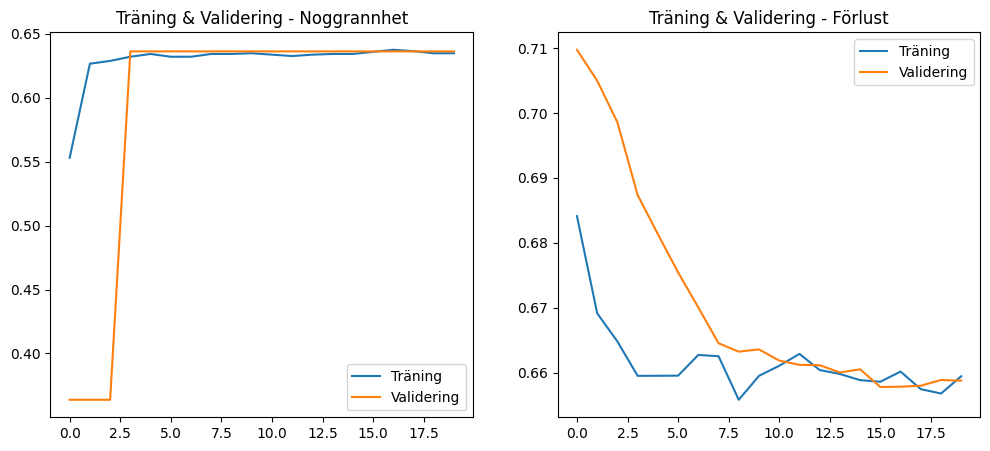

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,  
    width_shift_range=0.3,  
    height_shift_range=0.3, 
    shear_range=0.3,  
    zoom_range=0.3,  
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)


train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    "cnn_data_split/train/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_test_datagen.flow_from_directory(
    "cnn_data_split/val/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    "cnn_data_split/test/",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)


# Ladda en förtränad EfficientNetB0 utan topp-lager
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Frys basmodellens lager så de inte tränas i första steget
base_model.trainable = False

# Lägg till egna lager ovanpå basmodellen
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling för att minska dimensioner
x = Dense(512, activation="relu")(x)  # Fullt anslutet lager
x = Dropout(0.5)(x)  # Dropout för att undvika överträning
predictions = Dense(1, activation="sigmoid")(x)  # Sigmoid eftersom vi har två klasser

# Skapa den slutliga modellen
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilera modellen
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",  # Använd "categorical_crossentropy" om fler än två klasser
    metrics=["accuracy"]
)



# Beräkna klassvikter baserat på dina etiketter
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_generator.classes), 
    y=train_generator.classes
)

# Skapa en dictionary som tilldelar vikt till varje klass
class_weight_dict = dict(enumerate(class_weights))

# Träna modellen med klassvikter
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict,  # Lägg till klassvikterna här
    verbose=1
)

# Lås upp de sista 20 lagren för vidare träning
base_model.trainable = True
for layer in base_model.layers[:-20]:  
    layer.trainable = False  # Låt tidigare lager förbli låsta

# Kompilera igen med en lägre inlärningshastighet
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lägre LR för finjustering
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Träna modellen vidare


early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


loss, acc = model.evaluate(test_generator)
print(f"✅ Modellens testnoggrannhet: {acc:.2%}")

model.save("snowboard_vs_slalom_cnn.h5")
print("✅ Modell sparad som 'snowboard_vs_slalom_cnn.h5'")


def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    # Plotta träningens noggrannhet
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Träning")
    plt.plot(epochs_range, val_acc, label="Validering")
    plt.legend(loc="lower right")
    plt.title("Träning & Validering - Noggrannhet")

    # Plotta träningens förlustvärde
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Träning")
    plt.plot(epochs_range, val_loss, label="Validering")
    plt.legend(loc="upper right")
    plt.title("Träning & Validering - Förlust")

    plt.show()

plot_training(history_fine)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


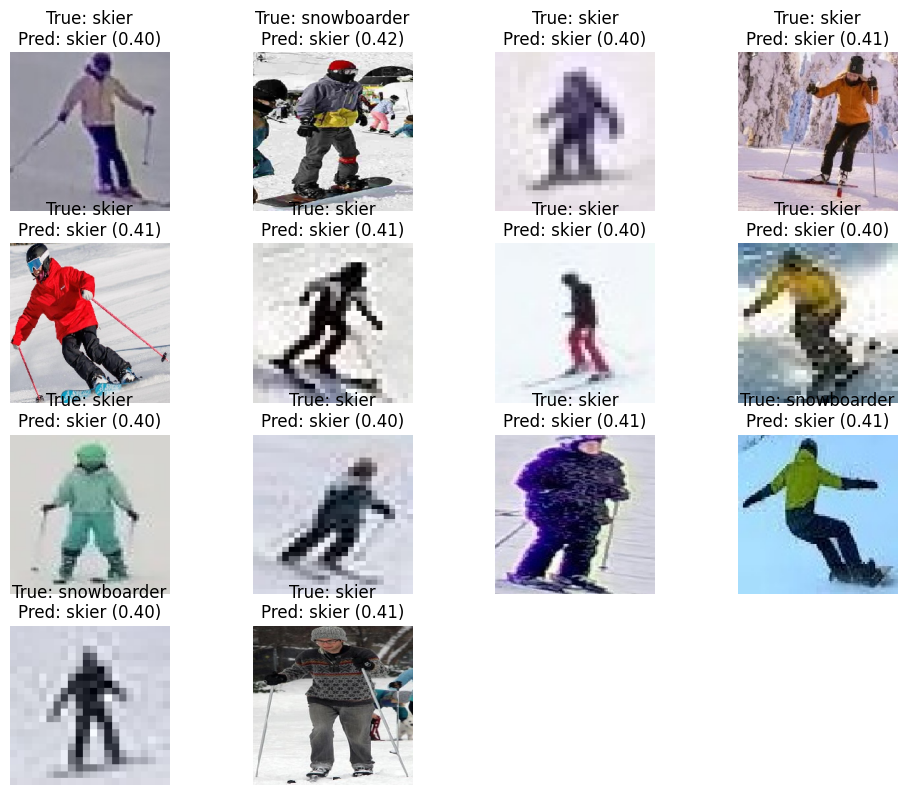

In [19]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Skapa en funktion för att göra förutsägelser och visa bilder
def test_sample_images(test_generator, model, num_images=10):
    # Hämta batchar av bilder från testgeneratorn
    class_names = test_generator.class_indices
    class_names = {v: k for k, v in class_names.items()}  # Byt klassindex till klassnamn
    class_0, class_1 = list(class_names.values())
    
    # Skapa en lista för att lagra bilder och förutsägelser
    test_images = []
    test_labels = []
    predictions = []

    for i, (images, labels) in enumerate(test_generator):
        if i >= num_images // 2:
            break
        
        # För varje klass (första klassen: 0, andra klassen: 1)
        for j in range(images.shape[0]):
            image_input = np.expand_dims(images[j], axis=0)  # Lägg till batch-dimensionen
            pred = model.predict(image_input)  # Gör en förutsägelse

            # Lägg till bilden, etiketten och förutsägelsen i listorna
            test_images.append(images[j])
            test_labels.append(labels[j])
            predictions.append(pred[0][0])

            # Avsluta när vi har samlat tillräckligt med bilder från denna klass
            if len(test_images) >= num_images:
                break

    # Visa de 10 bilderna med förutsägelser
    plt.figure(figsize=(12, 12))
    for i in range(len(test_images)):
        plt.subplot(5, 4, i+1)
        img = test_images[i]
        label = test_labels[i]
        pred = predictions[i]

        # Konvertera förutsägelsen till 0 eller 1
        pred_class = class_1 if pred >= 0.5 else class_0

        # Visa bilden med etikett och förutsägelse
        plt.imshow(img)
        plt.title(f"True: {class_1 if label == 1 else class_0}\nPred: {pred_class} ({pred:.2f})")
        plt.axis("off")

    plt.show()

# Använd funktionen för att testa och visa bilder
test_sample_images(test_generator, model, num_images=10)


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model


MODEL_PATH = "snowboard_vs_slalom_cnn.h5"  # Se till att modellen finns i samma mapp
model = load_model(MODEL_PATH)


IMG_SIZE = (224, 224)  # Bildstorlek måste matcha modellen

def preprocess_frame(frame):
    frame = cv2.resize(frame, IMG_SIZE) 
    frame = frame / 255.0  
    frame = np.expand_dims(frame, axis=0) 
    return frame


VIDEO_PATH = "./data/video2.mp4"  
cap = cv2.VideoCapture(VIDEO_PATH)

if not cap.isOpened():
    print("⚠️ Fel: Kunde inte öppna videofilen!")
    exit()

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output.avi", fourcc, 20.0, (int(cap.get(3)), int(cap.get(4))))

while True:
    ret, frame = cap.read()
    if not ret:
        break  # Avsluta om videon är slut

    processed_frame = preprocess_frame(frame)  # Förbered bilden
    prediction = model.predict(processed_frame)[0][0]  # Gör förutsägelse

    # Klassificering: 0 = Slalomåkare, 1 = Snowboardåkare
    label = "Snowboardåkare" if prediction > 0.5 else "Slalomåkare"
    confidence = int(prediction * 100) if prediction > 0.5 else int((1 - prediction) * 100)

  
    text = f"{label} ({confidence}%)"
    color = (0, 255, 0) if label == "Snowboardåkare" else (255, 0, 0)
    
    cv2.putText(frame, text, (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    cv2.imshow("Video Klassificering", frame)

    out.write(frame)  # Spara bildrutan i filen


    # Tryck 'q' för att avsluta
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()
print("✅ Videoklassificering avslutad!")




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━

OSError: [Errno 22] Invalid argument: 'C:\\Projects\\VisionComp\\cv-25-project\\cnn_data_split\test\\snowboarder\x02_1.jpg_0.jpg'

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 330ms/step - accuracy: 0.6399 - loss: 0.6558
Test Loss: 0.6574507355690002
Test Accuracy: 0.6363636255264282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
⛷ Prediktion: Slalomåkare (0.59)


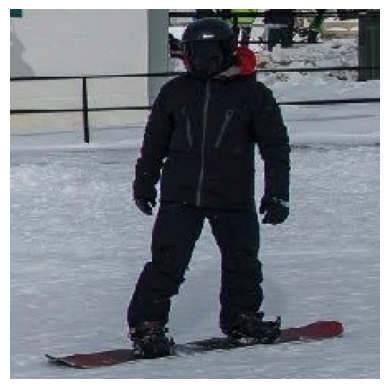

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
⛷ Prediktion: Slalomåkare (0.60)


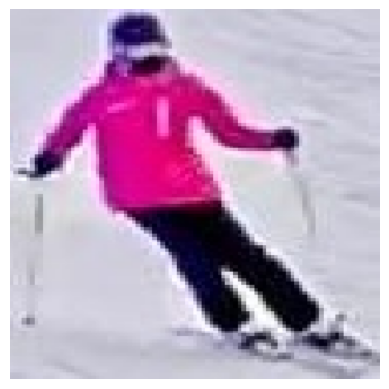

In [20]:
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img) / 255.0  # Normalisera
    img_array = np.expand_dims(img_array, axis=0)  # Lägg till batch-dimension
    
    prediction = model.predict(img_array)
    
    if prediction[0][0] > 0.5:
        print(f"🏂 Prediktion: Snowboarder ({prediction[0][0]:.2f})")
    else:
        print(f"⛷ Prediktion: Slalomåkare ({1 - prediction[0][0]:.2f})")

    plt.imshow(img)
    plt.axis("off")
    plt.show()

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Testa på en bild
predict_image(model, "./cnn_data_split/test/snowboarder/6_1.jpg_0.jpg")  
predict_image(model, "./cnn_data_split/test/skier/609_0.jpg_0.jpg")